# Задача 1.3.

---
Проверить мощность и консервативность критерия Уилкоксона о равенстве медиан для выборок вида:

X1: ~ alpha * N(0,1) + (1-alpha) * N(2, 4);

X2: ~ alpha * N(0,1) + (1-alpha) * N(2, 4) + delta.

Здесь delta --- сдвиг, дающий возможность разделить выборки X1 и X2.

Изучить зависимость от alpha и delta.

Важно: распределение является гауссовой смесью, это не сумма гауссовых величин пример как сэмплировать: https://stackoverflow.com/questions/49106806/how-to-do-a-simple-gaussian-mixture-sampling-and-pdf-plotting-with-numpy-scipy

---

!!! В данной задаче примем уровень значимости за 0.01.

In [214]:
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt
from tqdm import trange, tqdm

### 1. Семплирование gaussian mixture

In [96]:
# Set-up.
n = 1000
alpha = 0.5
delta = 0
n_components = 2

# Parameters of the mixture components
norm_params = np.array([[0, 1],[2,4]])

# Weight of each component
weights = np.array([alpha, 1-alpha])

- Семплирование X1:

In [97]:
np.random.seed(1)

# A stream of indices from which to choose the component
mixture_idx1 = np.random.choice(n_components, size=n, replace=True, p=weights)

# x1, x2 is the mixture samples
x1 = np.fromiter((ss.norm.rvs(*(norm_params[i])) for i in mixture_idx1), dtype=np.float64)

# Theoretical PDF plotting -- generate the x and y plotting positions
xs1 = np.linspace(x1.min(), x1.max(), 200)
ys1 = np.zeros_like(xs1)

for (l, s), w in zip(norm_params, weights):
    ys1 += ss.norm.pdf(xs1, loc=l, scale=s) * w

- Семплирование X2:

In [98]:
np.random.seed(2)

# A stream of indices from which to choose the component
mixture_idx2 = np.random.choice(n_components, size=n, replace=True, p=weights)

# x1, x2 is the mixture samples
x2 = np.fromiter((ss.norm.rvs(*(norm_params[i])) for i in mixture_idx2), dtype=np.float64) + delta

# Theoretical PDF plotting -- generate the x and y plotting positions
xs2 = np.linspace(x2.min(), x2.max(), 200)
ys2 = np.zeros_like(xs2)

for (l, s), w in zip(norm_params, weights):
    ys2 += ss.norm.pdf(xs2, loc=l, scale=s) * w
    

- Наглядное сравнение распределений X1 и X2 на графиках:

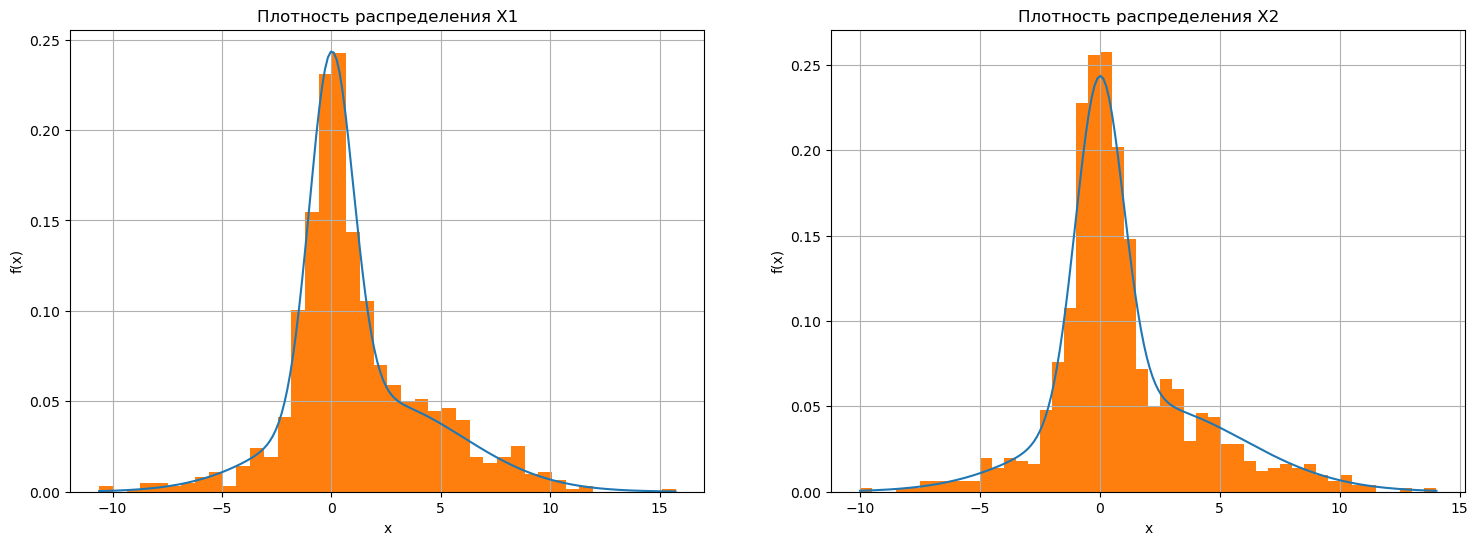

In [99]:
fig, ax = plt.subplots(1, 2, figsize=(18,6))

ax[0].grid()
ax[0].set_title('Плотность распределения X1')
ax[0].plot(xs1, ys1)
ax[0].hist(x1, density=True, bins='fd')
ax[0].set_xlabel("x")
ax[0].set_ylabel("f(x)")

ax[1].grid()
ax[1].set_title('Плотность распределения X2')
ax[1].plot(xs2+delta, ys2)
ax[1].hist(x2, density=True, bins="fd")
ax[1].set_xlabel("x")
ax[1].set_ylabel("f(x)")

None

### 2. Критерий Уилкоксона

<img src='1.png'>

http://www.machinelearning.ru/wiki/index.php?title=Критерий_Уилкоксона_для_связных_выборок

### 3. Проверка мощности критерия Уилкоксона

Чтобы проверить мощность критерия, нужно будет генерировать выборки, соответствующие альтернативной гипотезе, то есть с delta != 0, пусть к примеру delta=1. n_samples=1000 раз сгенерируем выборки, посчитаем p-value и определим долю
принятий нулевой гипотезы beta, после чего определим мощность критерия gamma = 1 - beta.

In [173]:
# Set-up.
n = 100
alpha = 0.5
delta = 1
n_components = 2
n_samples = 1000
significance_level = 0.01

# Parameters of the mixture components
norm_params = np.array([[0, 1],[2,4]])

# Weight of each component
weights = np.array([alpha, 1-alpha])

pvalue_list = []

for i in trange(n_samples):
    # A stream of indices from which to choose the component
    mixture_idx1 = np.random.choice(n_components, size=n, replace=True, p=weights)
    mixture_idx2 = np.random.choice(n_components, size=n, replace=True, p=weights)

    # x1, x2 is the mixture samples
    x1 = np.fromiter((ss.norm.rvs(*(norm_params[i])) for i in mixture_idx1), dtype=np.float64)
    x2 = np.fromiter((ss.norm.rvs(*(norm_params[i])) for i in mixture_idx2), dtype=np.float64) + delta
    
    res = ss.wilcoxon(x1-x2, alternative='two-sided')
    pvalue_list.append(res.pvalue)

100%|██████████████████████████████████████| 1000/1000 [00:04<00:00, 208.68it/s]


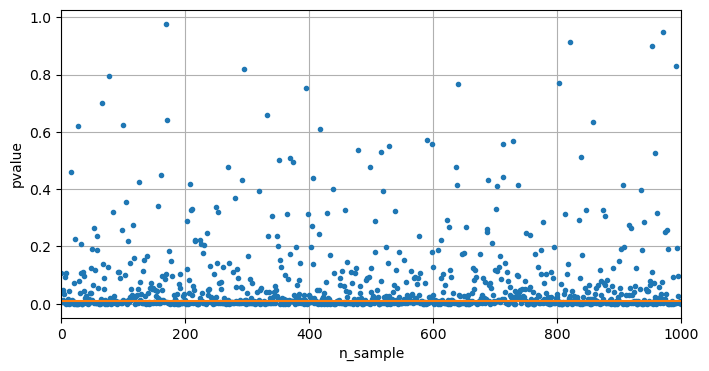

In [174]:
plt.figure(figsize=(8,4))
plt.grid()
plt.plot([i for i in range(n_samples)], pvalue_list, '.', label='pvalue')
plt.plot([i for i in range(n_samples)], [0.01 for i in range(n_samples)] ,label='significance level')
plt.xlim(0, n_samples)
plt.xlabel('n_sample')
plt.ylabel('pvalue')
plt.legend()

None

In [175]:
beta = np.sum(np.array(pvalue_list)>significance_level)/n_samples
print(f'Мощность критерия gamma = {round(1 - beta, 2)}')

Мощность критерия gamma = 0.45


### 4. Проверка консервативности критерия Уилкоксона

Чтобы проверить консервативность критерия, нужно будет генерировать выборки, соответствующие нулевой гипотезе, то есть с delta = 0. n_samples=1000 раз сгенерируем выборки, посчитаем p-value и определим долю отвержений нулевой гипотезы, после чего сравним с уровнем значимости significance_level=0.01: если доля окажется меньше, то критерий консервативный.

In [176]:
# Set-up.
n = 100
alpha = 0.5
delta = 0
n_components = 2
n_samples = 1000
significance_level = 0.01

# Parameters of the mixture components
norm_params = np.array([[0, 1],[2,4]])

# Weight of each component
weights = np.array([alpha, 1-alpha])

pvalue_list = []

for i in trange(n_samples):
    # A stream of indices from which to choose the component
    mixture_idx1 = np.random.choice(n_components, size=n, replace=True, p=weights)
    mixture_idx2 = np.random.choice(n_components, size=n, replace=True, p=weights)

    # x1, x2 is the mixture samples
    x1 = np.fromiter((ss.norm.rvs(*(norm_params[i])) for i in mixture_idx1), dtype=np.float64)
    x2 = np.fromiter((ss.norm.rvs(*(norm_params[i])) for i in mixture_idx2), dtype=np.float64) + delta
    
    res = ss.wilcoxon(x1-x2, alternative='two-sided')
    pvalue_list.append(res.pvalue)

100%|██████████████████████████████████████| 1000/1000 [00:04<00:00, 206.13it/s]


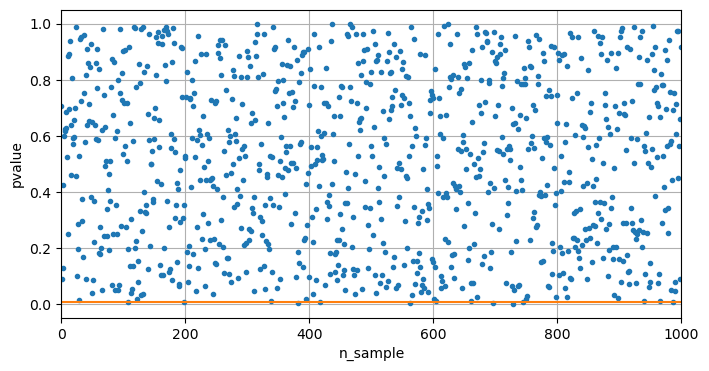

In [181]:
plt.figure(figsize=(8,4))
plt.grid()
plt.plot([i for i in range(n_samples)], pvalue_list, '.', label='pvalue')
plt.plot([i for i in range(n_samples)], [0.01 for i in range(n_samples)] ,label='significance level')
plt.xlim(0, n_samples)
plt.xlabel('n_sample')
plt.ylabel('pvalue')
plt.legend()

None

In [185]:
perc = np.sum(np.array(pvalue_list)<0.01)/n_samples
if perc < significance_level:
    print(f'Доля отвержений нулевой гипотезы равняется {round(perc, 3)}, что меньше, чем принятый нами уровень значимости {0.01}.')
    print('Таким образом, критерий консервативный.')
else:
    print(f'Доля отвержений нулевой гипотезы равняется {round(perc, 3)}, что не меньше, чем принятый нами уровень значимости {0.01}.')
    print('Таким образом, критерий не консервативный.')

Доля отвержений нулевой гипотезы равняется 0.009, что меньше, чем принятый нами уровень значимости 0.01.
Таким образом, критерий консервативный.


### 5. Исследование зависимости мощности критерия от alpha

Повторим пайплайн, используемый в пункте 3, при разных alpha, а именно при alpha=[0,0.1,0.2,...,1] и построим график зависимости мощности критерия в зависимости от alpha.

In [199]:
# Set-up.
alpha_list = [0.1*i for i in range(11)]

n = 100
delta = 1
n_components = 2
n_samples = 1000
significance_level = 0.01

# Parameters of the mixture components
norm_params = np.array([[0,1],[2,4]])

power_list = []

for alpha in tqdm(alpha_list):

    # Weight of each component
    weights = np.array([alpha, 1-alpha])

    pvalue_list = []

    for i in range(n_samples):
        # A stream of indices from which to choose the component
        mixture_idx1 = np.random.choice(n_components, size=n, replace=True, p=weights)
        mixture_idx2 = np.random.choice(n_components, size=n, replace=True, p=weights)

        # x1, x2 is the mixture samples
        x1 = np.fromiter((ss.norm.rvs(*(norm_params[i])) for i in mixture_idx1), dtype=np.float64)
        x2 = np.fromiter((ss.norm.rvs(*(norm_params[i])) for i in mixture_idx2), dtype=np.float64) + delta

        res = ss.wilcoxon(x1-x2, alternative='two-sided')
        pvalue_list.append(res.pvalue)
    
    beta = np.sum(np.array(pvalue_list)>significance_level)/n_samples
    power_list.append(1-beta)

100%|███████████████████████████████████████████| 11/11 [00:50<00:00,  4.62s/it]


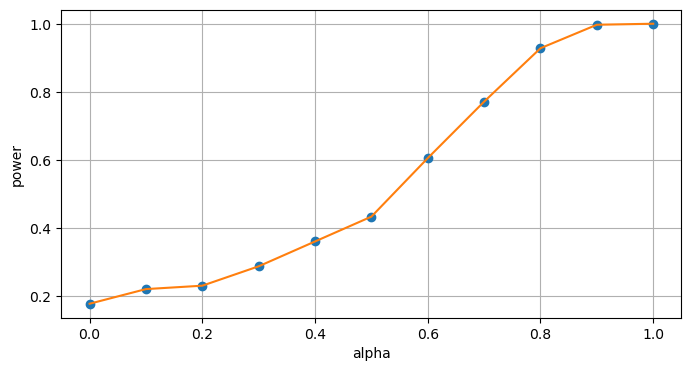

In [206]:
plt.figure(figsize=(8,4))
plt.grid()
plt.plot(alpha_list, power_list, 'o')
plt.plot(alpha_list, power_list, '-')
plt.xlabel('alpha')
plt.ylabel('power')
None

### 6. Исследование зависимости консервативности критерия от alpha 

Повторим пайплайн, используемый в пункте 4, при разных alpha, а именно при alpha=[0,0.1,0.2,...,1] и построим график зависимости консервативности критерия в зависимости от alpha.

In [201]:
# Set-up.
alpha_list = [0.1*i for i in range(11)]

n = 100
delta = 0
n_components = 2
n_samples = 1000
significance_level = 0.01

# Parameters of the mixture components
norm_params = np.array([[0, 1],[2,4]])

perc_list = []

for alpha in tqdm(alpha_list):

    # Weight of each component
    weights = np.array([alpha, 1-alpha])

    pvalue_list = []

    for i in range(n_samples):
        # A stream of indices from which to choose the component
        mixture_idx1 = np.random.choice(n_components, size=n, replace=True, p=weights)
        mixture_idx2 = np.random.choice(n_components, size=n, replace=True, p=weights)

        # x1, x2 is the mixture samples
        x1 = np.fromiter((ss.norm.rvs(*(norm_params[i])) for i in mixture_idx1), dtype=np.float64)
        x2 = np.fromiter((ss.norm.rvs(*(norm_params[i])) for i in mixture_idx2), dtype=np.float64) + delta

        res = ss.wilcoxon(x1-x2, alternative='two-sided')
        pvalue_list.append(res.pvalue)
    
    perc = np.sum(np.array(pvalue_list)<0.01)/n_samples
    perc_list.append(perc)

100%|███████████████████████████████████████████| 11/11 [00:51<00:00,  4.70s/it]


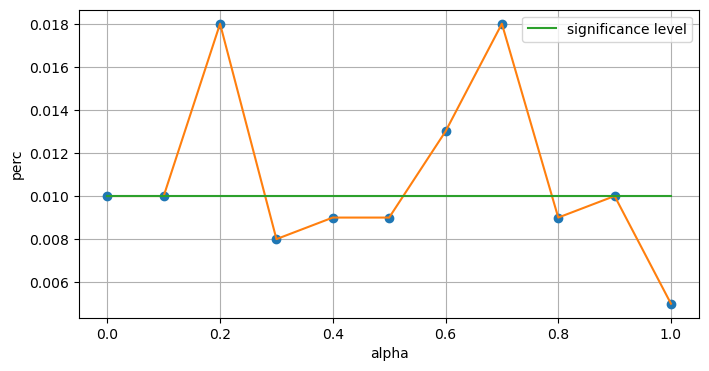

In [209]:
plt.figure(figsize=(8,4))
plt.grid()
plt.plot(alpha_list, perc_list, 'o')
plt.plot(alpha_list, perc_list, '-')
plt.plot(alpha_list, [significance_level for i in range(11)], label='significance level')
plt.xlabel('alpha')
plt.ylabel('perc')
plt.legend()
None

При alpha=0, 0.1, 0.3, 0.4, 0.5, 0.8, 1 критерий консервативен, в остальных случаях не консервативен.

### 7. Исследование зависимости мощности критерия от delta

Повторим пайплайн, используемый в пункте 3, при разных delta, а именно при delta=[0,0.5,1,1.5,2,2.5,3,3.5,4] и построим график зависимости мощности критерия в зависимости от delta.

In [210]:
# Set-up.
delta_list = [0,0.5,1,1.5,2,2.5,3,3.5,4]

n = 100
alpha = 0.5
n_components = 2
n_samples = 1000
significance_level = 0.01

# Parameters of the mixture components
norm_params = np.array([[0,1],[2,4]])

power_list = []

for delta in tqdm(delta_list):

    # Weight of each component
    weights = np.array([alpha, 1-alpha])

    pvalue_list = []

    for i in range(n_samples):
        # A stream of indices from which to choose the component
        mixture_idx1 = np.random.choice(n_components, size=n, replace=True, p=weights)
        mixture_idx2 = np.random.choice(n_components, size=n, replace=True, p=weights)

        # x1, x2 is the mixture samples
        x1 = np.fromiter((ss.norm.rvs(*(norm_params[i])) for i in mixture_idx1), dtype=np.float64)
        x2 = np.fromiter((ss.norm.rvs(*(norm_params[i])) for i in mixture_idx2), dtype=np.float64) + delta

        res = ss.wilcoxon(x1-x2, alternative='two-sided')
        pvalue_list.append(res.pvalue)
    
    beta = np.sum(np.array(pvalue_list)>significance_level)/n_samples
    power_list.append(1-beta)

100%|█████████████████████████████████████████████| 9/9 [00:42<00:00,  4.72s/it]


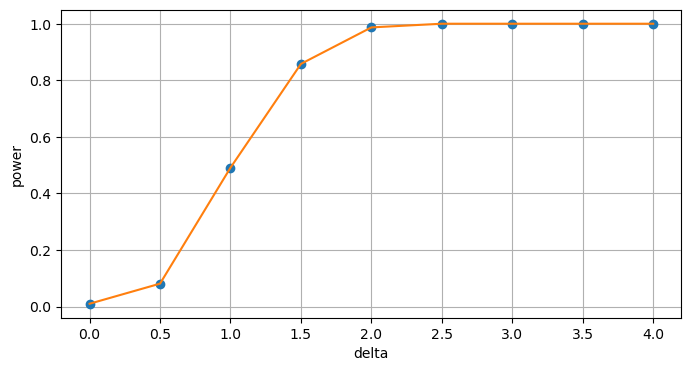

In [211]:
plt.figure(figsize=(8,4))
plt.grid()
plt.plot(delta_list, power_list, 'o')
plt.plot(delta_list, power_list, '-')
plt.xlabel('delta')
plt.ylabel('power')
None

### 8. Исследование зависимости консервативности критерия от delta

Повторим пайплайн, используемый в пункте 4, при разных delta, а именно при delta=[0,0.5,1,1.5,2,2.5,3,3.5,4] и построим график зависимости консервативности критерия в зависимости от delta.

In [212]:
# Set-up.
delta_list = [0,0.5,1,1.5,2,2.5,3,3.5,4]

n = 100
alpha = 0.5
n_components = 2
n_samples = 1000
significance_level = 0.01

# Parameters of the mixture components
norm_params = np.array([[0, 1],[2,4]])

perc_list = []

for delta in tqdm(delta_list):

    # Weight of each component
    weights = np.array([alpha, 1-alpha])

    pvalue_list = []

    for i in range(n_samples):
        # A stream of indices from which to choose the component
        mixture_idx1 = np.random.choice(n_components, size=n, replace=True, p=weights)
        mixture_idx2 = np.random.choice(n_components, size=n, replace=True, p=weights)

        # x1, x2 is the mixture samples
        x1 = np.fromiter((ss.norm.rvs(*(norm_params[i])) for i in mixture_idx1), dtype=np.float64)
        x2 = np.fromiter((ss.norm.rvs(*(norm_params[i])) for i in mixture_idx2), dtype=np.float64) + delta

        res = ss.wilcoxon(x1-x2, alternative='two-sided')
        pvalue_list.append(res.pvalue)
    
    perc = np.sum(np.array(pvalue_list)<0.01)/n_samples
    perc_list.append(perc)

100%|█████████████████████████████████████████████| 9/9 [00:42<00:00,  4.69s/it]


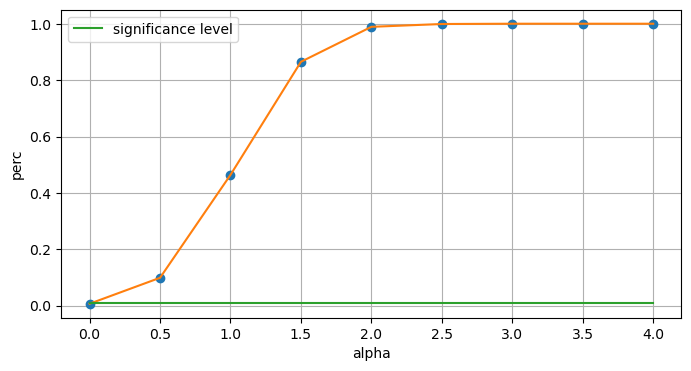

In [213]:
plt.figure(figsize=(8,4))
plt.grid()
plt.plot(delta_list, perc_list, 'o')
plt.plot(delta_list, perc_list, '-')
plt.plot(delta_list, [significance_level for i in range(9)], label='significance level')
plt.xlabel('alpha')
plt.ylabel('perc')
plt.legend()
None